<a href="https://colab.research.google.com/github/hamagami/ad2025/blob/main/LSTM_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install japanize-matplotlib -q
import matplotlib.pyplot as plt
import japanize_matplotlib  # これだけで日本語OK
plt.rcParams['axes.unicode_minus'] = False  # マイナス記号の豆腐対策

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 99.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


[Device] cuda
[INFO] 合成データで実行中...
Epoch 001 | train 1.015507 | val 0.916240
Epoch 002 | train 0.812895 | val 0.665593
Epoch 003 | train 0.613702 | val 0.352152
Epoch 004 | train 0.305050 | val 0.142414
Epoch 005 | train 0.204526 | val 0.106589
Epoch 006 | train 0.175767 | val 0.097587
Epoch 007 | train 0.159215 | val 0.091172
Epoch 008 | train 0.149130 | val 0.089685
Epoch 009 | train 0.139043 | val 0.069699
Epoch 010 | train 0.125128 | val 0.064111
Epoch 011 | train 0.118087 | val 0.057030
Epoch 012 | train 0.112076 | val 0.052591
Epoch 013 | train 0.104714 | val 0.048884
Epoch 014 | train 0.098608 | val 0.042967
Epoch 015 | train 0.094972 | val 0.043801
Epoch 016 | train 0.092303 | val 0.040380
Epoch 017 | train 0.087954 | val 0.036449
Epoch 018 | train 0.084765 | val 0.033304
Epoch 019 | train 0.082188 | val 0.038028
Epoch 020 | train 0.080922 | val 0.032293
Epoch 021 | train 0.078537 | val 0.031209
Epoch 022 | train 0.077020 | val 0.028862
Epoch 023 | train 0.074776 | val 0.028144


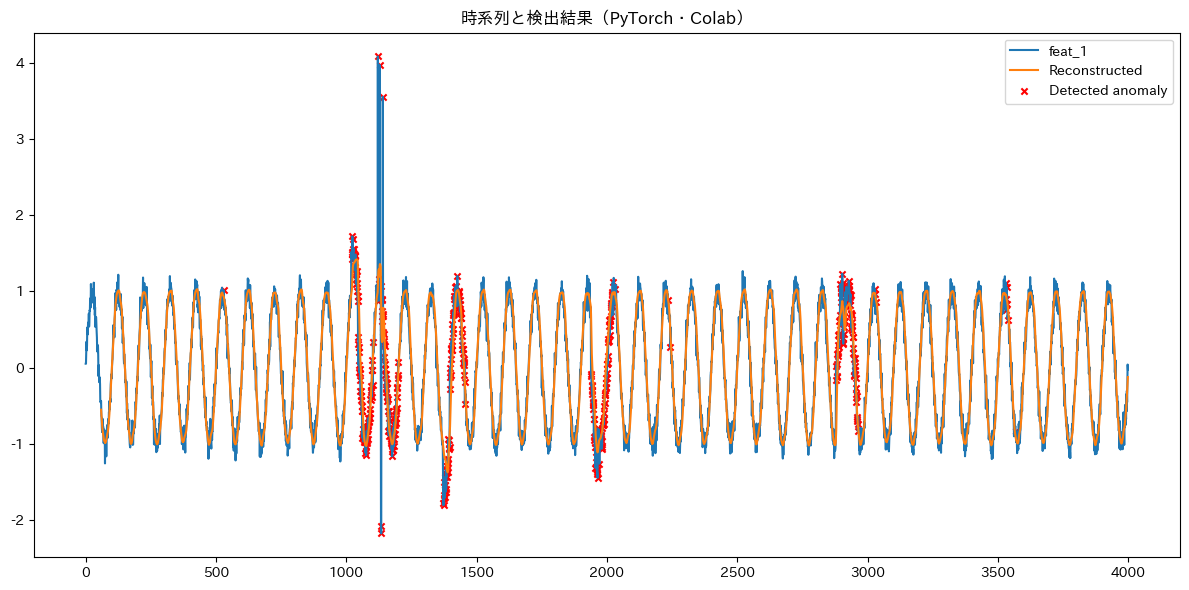

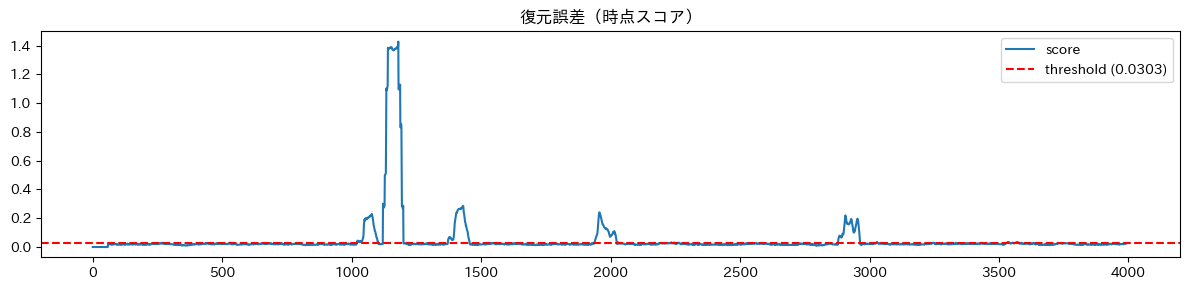

[DONE]


In [10]:
# LSTM復元誤差 異常検知（PyTorch・Colabセル分割版）

## 🔹 セル1: セットアップ（依存・デバイス・シード）

# ===== Imports =====
import os, random, math
from dataclasses import dataclass
from typing import Optional, Tuple

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ===== Device & Seed =====
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[Device] {device}")


## 🔹 セル2: 設定クラス

@dataclass
class Config:
    window_size: int = 60
    stride: int = 1
    latent_dim: int = 32
    batch_size: int = 128
    epochs: int = 50
    val_ratio: float = 0.2
    threshold_percentile: float = 99.0
    patience: int = 5
    lr: float = 1e-3


## 🔹 セル3: 合成データ & ウィンドウ化ユーティリティ


def make_synthetic_series(n_points: int = 4000,
                          n_anom_segments: int = 6,
                          anom_segment_len: int = 25,
                          noise_std: float = 0.1,
                          level_shift_scale: float = 1.5,
                          spike_scale: float = 3.0,
                          multivariate: int = 1) -> Tuple[pd.DataFrame, np.ndarray]:
    t = np.arange(n_points)
    df = pd.DataFrame()
    for i in range(multivariate):
        phase = i * 0.4
        amp = 1.0 + 0.2 * i
        base = amp * np.sin(2 * np.pi * t / 100 + phase)
        series = base + np.random.normal(0, noise_std, size=n_points)
        df[f"feat_{i+1}"] = series
    y_true = np.zeros(n_points, dtype=int)
    for _ in range(n_anom_segments):
        start = np.random.randint(100, n_points - anom_segment_len - 1)
        end = start + anom_segment_len
        y_true[start:end] = 1
        if np.random.rand() < 0.5:
            shift = (np.random.rand() * 2 - 1) * level_shift_scale
            for col in df.columns:
                df.loc[start:end, col] += shift
        else:
            n_spikes = max(3, anom_segment_len // 5)
            idxs = np.random.choice(np.arange(start, end), size=n_spikes, replace=False)
            for col in df.columns:
                df.loc[idxs, col] += np.random.choice([-1, 1], size=n_spikes) * spike_scale
    return df, y_true


def make_windows(X: np.ndarray, window_size: int, stride: int) -> np.ndarray:
    T, F = X.shape
    windows = []
    for start in range(0, T - window_size + 1, stride):
        end = start + window_size
        windows.append(X[start:end])
    return np.stack(windows, axis=0)  # (N, W, F)


def windows_to_pointwise(scores: np.ndarray, n_points: int, window_size: int, stride: int) -> np.ndarray:
    point_scores = np.zeros(n_points)
    count = np.zeros(n_points)
    idx = 0
    for start in range(0, n_points - window_size + 1, stride):
        end_idx = start + window_size - 1
        point_scores[end_idx] += scores[idx]
        count[end_idx] += 1
        idx += 1
    nz = count > 0
    point_scores[nz] = point_scores[nz] / count[nz]
    return point_scores


## 🔹 セル4: Dataset と モデル


class WindowDataset(Dataset):
    def __init__(self, Xw: np.ndarray):
        self.Xw = Xw.astype(np.float32)
    def __len__(self):
        return self.Xw.shape[0]
    def __getitem__(self, idx):
        x = self.Xw[idx]  # (W, F)
        return torch.from_numpy(x)


class LSTMAutoencoder(nn.Module):
    def __init__(self, timesteps: int, n_features: int, latent_dim: int):
        super().__init__()
        self.timesteps = timesteps
        self.enc_lstm1 = nn.LSTM(input_size=n_features, hidden_size=64, batch_first=True)
        self.enc_dropout = nn.Dropout(0.2)
        self.enc_lstm2 = nn.LSTM(input_size=64, hidden_size=latent_dim, batch_first=True)
        self.dec_lstm1 = nn.LSTM(input_size=latent_dim, hidden_size=latent_dim, batch_first=True)
        self.dec_dropout = nn.Dropout(0.2)
        self.dec_lstm2 = nn.LSTM(input_size=latent_dim, hidden_size=64, batch_first=True)
        self.out = nn.Linear(64, n_features)
    def forward(self, x):
        x, _ = self.enc_lstm1(x)
        x = self.enc_dropout(x)
        _, (h_n, _) = self.enc_lstm2(x)
        z = h_n[-1]
        z_rep = z.unsqueeze(1).repeat(1, self.timesteps, 1)
        y, _ = self.dec_lstm1(z_rep)
        y = self.dec_dropout(y)
        y, _ = self.dec_lstm2(y)
        out = self.out(y)
        return out

## 🔹 セル5: 学習/評価ユーティリティ


def train_epoch(model, loader, opt, criterion):
    model.train()
    total, n = 0.0, 0
    for x in loader:
        x = x.to(device)
        opt.zero_grad()
        y = model(x)
        loss = criterion(y, x)
        loss.backward()
        opt.step()
        total += loss.item() * x.size(0)
        n += x.size(0)
    return total / max(1, n)


def eval_epoch(model, loader, criterion):
    model.eval()
    total, n = 0.0, 0
    with torch.no_grad():
        for x in loader:
            x = x.to(device)
            y = model(x)
            loss = criterion(y, x)
            total += loss.item() * x.size(0)
            n += x.size(0)
    return total / max(1, n)


def reconstruction_errors(model, Xw: np.ndarray, batch_size: int = 512):
    ds = WindowDataset(Xw)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False)
    model.eval()
    errs, recons = [], []
    with torch.no_grad():
        for x in dl:
            x = x.to(device)
            y = model(x)
            mse = torch.mean((x - y) ** 2, dim=(1, 2))
            errs.append(mse.cpu().numpy())
            recons.append(y.cpu().numpy())
    return np.concatenate(errs, 0), np.concatenate(recons, 0)


## 🔹 セル6: 学習→検出（関数化）

def fit_and_detect(df: pd.DataFrame, cfg: Config, y_true_point: Optional[np.ndarray] = None):
    values = df.values.astype("float32")
    scaler = StandardScaler()
    values_norm = scaler.fit_transform(values)
    Xw = make_windows(values_norm, cfg.window_size, cfg.stride)

    n_windows = Xw.shape[0]
    split = int(n_windows * (1 - cfg.val_ratio))
    Xw_train, Xw_val = Xw[:split], Xw[split:]

    train_loader = DataLoader(WindowDataset(Xw_train), batch_size=cfg.batch_size, shuffle=True)
    val_loader = DataLoader(WindowDataset(Xw_val), batch_size=cfg.batch_size, shuffle=False)

    model = LSTMAutoencoder(cfg.window_size, values.shape[1], cfg.latent_dim).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=cfg.lr)
    criterion = nn.MSELoss()

    best_val, best_state, no_improve = float("inf"), None, 0
    history = {"train_loss": [], "val_loss": []}

    for epoch in range(1, cfg.epochs + 1):
        tr = train_epoch(model, train_loader, opt, criterion)
        va = eval_epoch(model, val_loader, criterion)
        history["train_loss"].append(tr)
        history["val_loss"].append(va)
        print(f"Epoch {epoch:03d} | train {tr:.6f} | val {va:.6f}")
        if va < best_val - 1e-6:
            best_val, best_state, no_improve = va, {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}, 0
        else:
            no_improve += 1
        if no_improve >= cfg.patience:
            print("Early stopping!")
            break
    if best_state is not None:
        model.load_state_dict(best_state)

    val_errors, val_recons = reconstruction_errors(model, Xw_val)
    threshold = float(np.percentile(val_errors, cfg.threshold_percentile))

    all_errors, all_recons = reconstruction_errors(model, Xw)
    point_scores = windows_to_pointwise(all_errors, n_points=len(df), window_size=cfg.window_size, stride=cfg.stride)
    point_pred = (point_scores > threshold).astype(int)

    metrics = {}
    if y_true_point is not None:
        from sklearn.metrics import precision_recall_fscore_support
        prec, rec, f1, _ = precision_recall_fscore_support(y_true_point, point_pred, average="binary", zero_division=0)
        metrics = {"precision": float(prec), "recall": float(rec), "f1": float(f1)}
        print("[Metrics]", metrics)

    return {"model": model, "scaler": scaler, "threshold": threshold,
            "point_scores": point_scores, "point_pred": point_pred,
            "history": history, "metrics": metrics, "reconstructions": all_recons, "Xw": Xw, "values_norm": values_norm}


## 🔹 セル7: 可視化関数


def plot_results(df: pd.DataFrame, point_scores: np.ndarray, threshold: float, point_pred: np.ndarray, reconstructions: np.ndarray, Xw: np.ndarray, values_norm: np.ndarray, window_size: int, scaler: StandardScaler, title_prefix: str = "PyTorch"):
    plt.figure(figsize=(12, 6))
    plt.title(f"時系列と検出結果（{title_prefix}）")
    plt.plot(df.index, df.iloc[:, 0].values, label=df.columns[0])

    # Plot reconstructed series (adjusting index for plotting)
    # The reconstruction is for each window. To plot it against the original series,
    # we can take the last point of each reconstructed window, which corresponds to the last point of the original window.
    n_windows = reconstructions.shape[0]
    reconstructed_series = np.zeros(len(df))
    reconstructed_series[:] = np.nan # Initialize with NaN to avoid plotting where no reconstruction is available

    for i in range(n_windows):
        original_end_idx = i * 1 + window_size - 1 # Assuming stride is 1
        if original_end_idx < len(df):
             reconstructed_series[original_end_idx] = reconstructions[i, -1, 0] # Take the last point of the first feature

    # Inverse transform the reconstructed series
    # Create a temporary array with correct shape for inverse_transform
    temp_reconstructed = np.tile(values_norm[0, :], (len(df), 1)) # Use the first row for shape
    temp_reconstructed[:, 0] = reconstructed_series # Replace the first feature with the reconstructed values

    # Find indices where reconstruction is not NaN
    valid_indices = ~np.isnan(temp_reconstructed[:, 0])

    if np.any(valid_indices):
        reconstructed_original_scale = np.zeros_like(temp_reconstructed)
        reconstructed_original_scale[valid_indices, :] = scaler.inverse_transform(temp_reconstructed[valid_indices, :])

        plt.plot(df.index[valid_indices], reconstructed_original_scale[valid_indices, 0], label="Reconstructed")

    anom_idx = np.where(point_pred == 1)[0]
    if len(anom_idx) > 0:
        plt.scatter(anom_idx, df.iloc[anom_idx, 0].values, color='red', s=20, marker="x", label="Detected anomaly") # Changed color and size
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(12, 3))
    plt.title("復元誤差（時点スコア）")
    plt.plot(point_scores, label="score")
    plt.axhline(threshold, linestyle="--", color='red', label=f"threshold ({threshold:.4f})") # Changed color
    plt.legend(); plt.tight_layout(); plt.show()


## 🔹 セル8: 実行設定（フォーム）


#@title 実行設定 { form-width: "380px" }
MODE = "demo" #@param ["demo", "csv"]
CSV_PATH = "" #@param {type:"string"}
COLUMNS = "" #@param {type:"string"}

# 学習ハイパーパラメータ
window_size = 60 #@param {type:"integer"}
stride = 1 #@param {type:"integer"}
latent_dim = 32 #@param {type:"integer"}
epochs = 50 #@param {type:"integer"}
batch_size = 128 #@param {type:"integer"}
val_ratio = 0.2 #@param {type:"number"}
percentile = 99.0 #@param {type:"number"}
patience = 5 #@param {type:"integer"}
lr = 1e-3 #@param {type:"number"}

cfg = Config(window_size=window_size, stride=stride, latent_dim=latent_dim,
             batch_size=batch_size, epochs=epochs, val_ratio=val_ratio,
             threshold_percentile=percentile, patience=patience, lr=lr)


## 🔹 セル9: 実行（学習→検出→可視化）


if MODE == "demo":
    print("[INFO] 合成データで実行中...")
    df, y_true = make_synthetic_series(n_points=4000, multivariate=1)
    results = fit_and_detect(df, cfg, y_true_point=y_true)
else:
    assert CSV_PATH, "MODE='csv' の場合は CSV_PATH を指定してください。"
    print(f"[INFO] CSV読み込み: {CSV_PATH}")
    df = pd.read_csv(CSV_PATH)
    if COLUMNS:
        cols = [c.strip() for c in COLUMNS.split(",")]
        df = df[cols]
    df = df.dropna().reset_index(drop=True)
    print(f"[INFO] 形状: {df.shape}")
    results = fit_and_detect(df, cfg)

plot_results(df, results["point_scores"], results["threshold"], results["point_pred"],
             results["reconstructions"], results["Xw"], results["values_norm"], cfg.window_size, results["scaler"], title_prefix="PyTorch・Colab")
print("[DONE]")